In [13]:
#载入所需package
import numpy as np
import torch
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mping 
import cmath
from torch import nn
import random
from torch.utils import data
import copy
from scipy.special import kv
from scipy import integrate
import seaborn as sns
import matplotlib as mpl

## Rejection Method

### Characteristic Function

In [14]:
class Characteristic_function:
    def __init__(self,data):
        self.data = data   
    def ecf(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    def ecf_h(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                r = (math.sqrt(s**2+c**2))**h
                theta = math.atan(s/c)*h
                c_h = r*math.cos(theta)
                s_h = r*math.sin(theta)
                R = R+[c_h]
                R = R+[s_h]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    

In [15]:
class rejection_method:    
    def __init__(self,h,n,v,mu = 0,sigma = 1):        
        self.h = h
        self.v = v
        self.mu = mu
        self.sigma = sigma
        self.n = n
    def phi_h(self,t):
        phi_real = math.cos(t*self.mu)*((math.sqrt(self.v)*self.sigma*abs(t))**(self.v/2))/(2**(self.v/2-1)*math.gamma(self.v/2))*kv(self.v/2,math.sqrt(self.v)*self.sigma*abs(t))
        phi_imag = math.sin(t*self.mu)*((math.sqrt(self.v)*self.sigma*abs(t))**(self.v/2))/(2**(self.v/2-1)*math.gamma(self.v/2))*kv(self.v/2,math.sqrt(self.v)*self.sigma*abs(t))
        r = (math.sqrt(phi_real**2+phi_imag**2))**self.h
        theta = math.atan(phi_imag/phi_real)*self.h
        phi_real = r*math.cos(theta)
        phi_imag = r*math.sin(theta)
        phi_abs = math.sqrt(phi_real**2+phi_imag**2)
        return phi_real, phi_imag, phi_abs
    def f(self,x,t_lim=200,t_num=2000):
        t = torch.linspace(-int(t_lim),int(t_lim),t_num)
        intg = []
        #因为密度是real的
        for i in range(t_num):
            r = self.phi_h(t[i])[0]
            im = self.phi_h(t[i])[1]
            intg += [math.cos(t[i]*x)*r+math.sin(t[i]*x)*im]
        y = 1/(2*math.pi)*integrate.trapz(intg, t)
        return y
    def phi_abs0(self,t):
        return self.phi_h(t)[2]
    def phi_prime(self,t,delt = 0.0001):
        d_1 = (self.phi_h(t)[0]-self.phi_h(t+delt)[0])/delt
        d_2 = (self.phi_h(t)[1]-self.phi_h(t+delt)[1])/delt
        d_abs = math.sqrt(d_1**2+d_2**2)
        return d_1,d_2
    def phi_prime_prime(self,t,delt = 0.0001):
        d_1 = (self.phi_prime(t)[0]-self.phi_prime(t+delt)[0])/delt
        d_2 = (self.phi_prime(t)[1]-self.phi_prime(t+delt)[1])/delt
        d_abs = math.sqrt(d_1**2+d_2**2)
        return d_1,d_2,d_abs  
    def phi_abs2(self,t):
        return self.phi_prime_prime(t)[2]
    def integ(self,domain = 100,ndots = 500):
        t = torch.linspace(-int(domain),int(domain),ndots)
        intg_0 = []
        intg_2 = []
        for i in range(len(t)):
            intg_0 += [self.phi_abs0(t[i])]
        c = 1/(2*math.pi)*integrate.trapz(intg_0, t)
        for i in range(len(t)):
            intg_2 += [self.phi_abs2(t[i])]
        k = 1/(2*math.pi)*integrate.trapz(intg_2, t)
        return c,k
    def hat_function(self,x):        
        c,k = self.integ()
        g = min(c,k/(x**2))
        return g

    def genertator(self):
        total = 25*self.n
        V_1 = np.random.uniform(-1,1,total)
        V_2 = np.random.uniform(-1,1,total)
        c,k = self.integ()
        X = []
        for i in range(total):
            y = math.sqrt(k/c)*(V_1[i]/V_2[i])
            U = np.random.uniform(-1,1)            
            if len(X) >=self.n:
                break
                
            elif U<= (self.f(y)/self.hat_function(y)):
                X+=[y]
            else:
                continue
        return X
        
    @staticmethod
    def cumulate(delta):
        data = torch.zeros(np.shape(delta))
        n = np.shape(delta)[0]
        for i in range(n-1):
            data[i+1] = data[i]+delta[i]
        return np.array(data)    

## Frequency Changing

In [16]:
class Characteristic_function:
    def __init__(self,data):
        self.data = data   
    def ecf(self,t):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R
    def ecf_h(self,t,h):
        n = len(self.data)
        if type(t)== int:
            C = torch.zeros((n,1))
            S = torch.zeros((n,1))
            for i in range(n):
                C[i] = math.cos(t*self.data[i])
                S[i] = math.sin(t*self.data[i])
            s = torch.mean(S)
            c = torch.mean(C)
            r = math.sqrt(s**2+c**2)**h
            theta = math.atan(s/c)*h
            s = math.sin(theta)*r
            c = math.cos(theta)*r
            return c,s                
        else:    
            m = len(t)
            R = []
            for j in range(m):
                S = []
                C = []
                for i in range(n):
                    C = C+[math.cos(t[j]*self.data[i])]
                    S = S+[math.sin(t[j]*self.data[i])]
                #S = torch.tensor(S,dtype = torch.float64)
                #C = torch.tensor(C,dtype = torch.float64)
                s = sum(S)/len(S)
                c = sum(C)/len(C)
                r = math.sqrt(s**2+c**2)**h
                theta = math.atan(s/c)*h
                s = math.sin(theta)*r
                c = math.cos(theta)*r
                R = R+[c]
                R = R+[s]
            #R = torch.tensor(R,dtype = torch.float64)
        return R


## 实例化rejection method(h =2,mu = 0,sigma = 1,v =3)

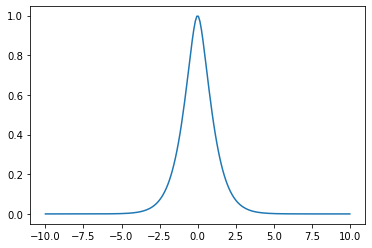

In [27]:
rm = rejection_method(h = 1,n = 1000,v =3)
num_t = 200
range_t = 10
t = torch.linspace(-range_t,range_t,num_t,dtype = torch.float64)
intg_0 = []
for i in range(len(t)):
    intg_0 += [rm.phi_h(t[i])[0]]
plt.plot(t,intg_0)

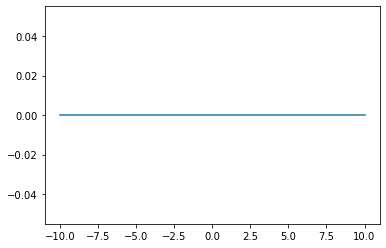

In [62]:
intg_0 = []
for i in range(len(t)):
    intg_0 += [rm.phi_h(t[i])[1]]
plt.plot(t,intg_0)

## rejection method 生成数据

In [23]:
x = rm.genertator()

## 生成数据的可视化

In [28]:
X = torch.tensor(x)
x_show = []
for i in range(len(x)):
    if abs(x[i])<7:
        x_show+=[x[i]]
len(x_show)

824

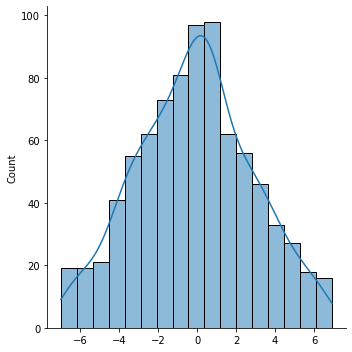

In [29]:
fig = sns.displot(data = x_show,kind = 'hist',kde = "TRUE")


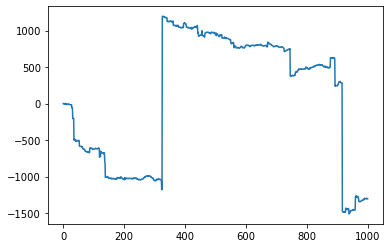

In [30]:
path = rm.cumulate(x)
plt.plot(path)

## Training Settings

In [31]:
num_feature = 100  #x的个数
range_feature = 20 #x的范围
num_sample = 100   #有几对
num_labels = num_t
total = num_sample*num_feature
#t = t.reshape((-1,len(t)))
feat = torch.linspace(-range_feature,range_feature,num_feature,dtype = torch.float64)

## 计算label 即经验特征函数

In [35]:
#实例化(V =3)
CF = Characteristic_function(x)
labels = CF.ecf_h(t,1)

In [36]:
len(t)

200

In [37]:
a = []
features = []
label = []
for i in range(num_sample):
    label+=labels
    features+=feat
labels =torch.tensor(label,dtype = torch.float64).reshape((-1,2*num_labels))
features = torch.tensor(features,dtype = torch.float64).reshape((-1,num_feature))

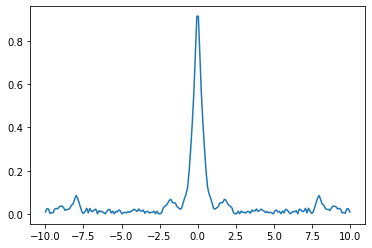

In [38]:
##labels可视化
real = torch.zeros(int(len(labels[0])/2)+1)
image = torch.zeros(int(len(labels[0])/2)+1)
for i in range(len(labels[0])):
    if i%2 ==0:
        real[int(i/2)] = labels[0][i]
    else:
        image[int((i+1)/2)] = labels[0][i]
real = real[0:len(t)]
plt.plot(t,real)

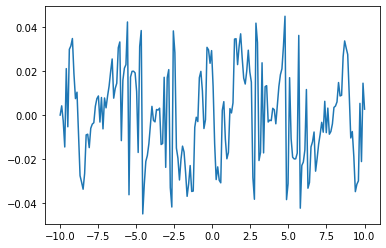

In [61]:
image = image[0:len(t)]
plt.plot(t,image)

In [39]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size = 1
D_loader = load_array((features,labels), batch_size)

In [40]:
next(iter(D_loader))[0].shape

torch.Size([1, 100])

In [41]:
# 初始化参数定义


hidden_2, hidden_3 = 256, 256

W1 = nn.Parameter(torch.randn(
    num_feature, hidden_2, requires_grad=True,dtype = torch.float64) * 0.01)
b1 = nn.Parameter(torch.zeros(hidden_2, requires_grad=True,dtype = torch.float64))

W2 = nn.Parameter(torch.randn(
    hidden_2, hidden_3, requires_grad=True,dtype = torch.float64) * 0.01)
b2 = nn.Parameter(torch.zeros(hidden_3, requires_grad=True,dtype = torch.float64))

W3 = nn.Parameter(torch.randn(
    hidden_3, num_feature, requires_grad=True,dtype = torch.float64) * 0.01)
b3 = nn.Parameter(torch.zeros(num_feature, requires_grad=True,dtype = torch.float64))


params = [W1, b1, W2, b2, W3, b3]

In [42]:
#激活函数
def relu(X):
    a = torch.zeros_like(X)
    b = torch.max(X, a)
    return torch.tensor(b,dtype = torch.float64)
def expcostx(x,V):
    a = t.reshape((-1,1))@x.reshape((1,-1))
    b = (torch.cos(a)-1)@V.reshape((-1,1))
    c = torch.exp((range_feature*2/num_feature)*b)
    return c
def I(x):
    y = copy.deepcopy(x)
    y[abs(x)>1]=0
    return y
    
def realtx(x,V):
    x = torch.tensor(x,dtype = torch.float64)
    a1 = torch.sin(t.reshape((-1,1))@x.reshape((1,-1))) 
    a2 = t.reshape((-1,1))@I(x).reshape((1,-1))
    a3 = a1+a2
    a4 = a3@V.reshape((-1,1))
    a5 = (range_feature*2/num_feature)*a4
    a6 = torch.cos(a5)
    return a6
def imagetx(x,V):
    #x = torch.tensor(x,dtype = torch.float64)
    a1 = torch.sin(t.reshape((-1,1))@x.reshape((1,-1))) 
    a2 = t.reshape((-1,1))@I(x).reshape((1,-1))
    a3 = a1+a2
    a4 = a3@V.reshape((-1,1))
    a5 = (range_feature*2/num_feature)*a4
    a6 = torch.sin(a5)
    return a6

In [43]:
#网络定义
def net_1(X):
    X_clone = X.clone()
    X = X.reshape((-1, num_feature))
    H1 = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    H2 = relu(H1@W2 + b2)
    V = (H2@W3 + b3)
    R_1 = expcostx(X,V)*realtx(X,V)
    R_2 = expcostx(X,V)*imagetx(X,V)
    R = torch.cat((R_1,R_2),1).reshape((1,-1))
    return R


In [44]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [45]:
lr = 0.02
num_epochs = int(num_sample/batch_size)
net = net_1
loss = nn.MSELoss()

trainer = torch.optim.SGD(params, lr=0.03)

In [46]:
for epoch in range(num_epochs):
    for X, y in D_loader:
        l = loss(net_1(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(X), y)
    print(f'epoch {epoch + 1}, loss {l:f}')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3408\1528106951.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3408\1528106951.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype = torch.float64)


epoch 1, loss 0.005937
epoch 2, loss 0.005707
epoch 3, loss 0.005585
epoch 4, loss 0.005472
epoch 5, loss 0.005351
epoch 6, loss 0.005216
epoch 7, loss 0.005064
epoch 8, loss 0.004891
epoch 9, loss 0.004691
epoch 10, loss 0.004460
epoch 11, loss 0.004192
epoch 12, loss 0.003888
epoch 13, loss 0.003553
epoch 14, loss 0.003207
epoch 15, loss 0.002880
epoch 16, loss 0.002597
epoch 17, loss 0.002365
epoch 18, loss 0.002176
epoch 19, loss 0.002020
epoch 20, loss 0.001884
epoch 21, loss 0.001763
epoch 22, loss 0.001652
epoch 23, loss 0.001548
epoch 24, loss 0.001452
epoch 25, loss 0.001362
epoch 26, loss 0.001280
epoch 27, loss 0.001205
epoch 28, loss 0.001137
epoch 29, loss 0.001078
epoch 30, loss 0.001025
epoch 31, loss 0.000979
epoch 32, loss 0.000938
epoch 33, loss 0.000903
epoch 34, loss 0.000871
epoch 35, loss 0.000842
epoch 36, loss 0.000817
epoch 37, loss 0.000794
epoch 38, loss 0.000772
epoch 39, loss 0.000753
epoch 40, loss 0.000734
epoch 41, loss 0.000717
epoch 42, loss 0.000700
e

## visualized characteristic function(real)

In [47]:
predict0 = list(net_1(features[0]))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3408\1528106951.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(b,dtype = torch.float64)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_3408\1528106951.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x,dtype = torch.float64)


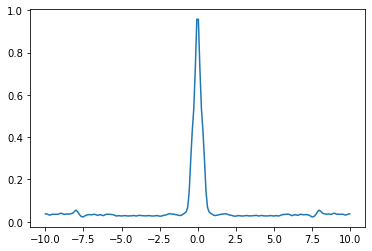

In [48]:
real_h = torch.zeros(int(len(labels[0])/2)+1)
image_h = torch.zeros(int(len(labels[0])/2)+1)
for i in range(len(labels[0])):
    if i%2 ==0:
        real_h[int(i/2)] = predict0[0][i]
    else:
        image_h[int((i+1)/2)] = predict0[0][i]
real_h = real_h[0:len(t)] 
image_h = image_h[0:len(t)] 
plt.plot(t,real_h.detach().numpy())

In [49]:
#c的值
abs_0 = []
for i in range(len(real_h)):
    abs_0+=[math.sqrt(real_h[i]**2+image_h[i]**2)]

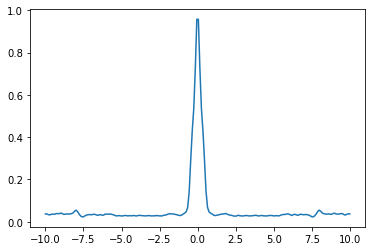

In [50]:
plt.plot(t,abs_0)

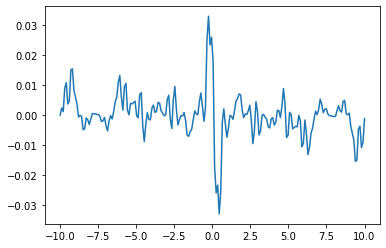

In [51]:
plt.plot(t,image_h.detach().numpy())

In [52]:
c = 1/(2*math.pi)*integrate.trapz(abs_0, t)

In [53]:
# k值
prime_real = []
prime_imag = []
for i in range(len(t)-1):
    prime_real +=[(real_h[i+1]-real_h[i])/(t[i+1]-t[i])]
    prime_imag +=[(image_h[i+1]-image_h[i])/(t[i+1]-t[i])]

In [54]:
prime2_real = []
prime2_imag = []
abs_2 = []
for i in range(len(t)-2):
    prime2_real +=[(prime_real[i+1]-prime_real[i])/(t[i+1]-t[i])]
    prime2_imag +=[(prime_imag[i+1]-prime_imag[i])/(t[i+1]-t[i])]
    abs_2 += [math.sqrt(prime2_real[-1]**2+prime2_imag[-1]**2)]


In [55]:
len(t[0:-2])

198

In [56]:
k =  1/(2*math.pi)*integrate.trapz(abs_2, t[0:-2])

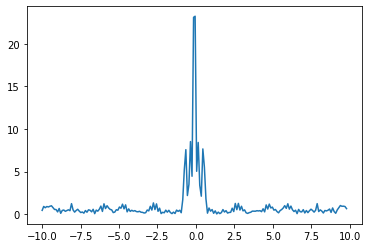

In [57]:
plt.plot(t[0:-2],abs_2)

In [58]:
def hat_function_h(x):        
    g = min(c,k/(x**2))
    return g
def genertator_h(n):
    total = 25*n
    V_1 = np.random.uniform(-1,1,total)
    V_2 = np.random.uniform(-1,1,total)
    X = []
    for i in range(total):
        y = math.sqrt(k/c)*(V_1[i]/V_2[i])
        U = np.random.uniform(-1,1)            
        if len(X) >=n:
            break
                
        elif U<= (f_h(y)/hat_function_h(y)):
            X+=[y]
        else:
            continue
    return X
def f_h(x):
    intg = []
    #因为密度是real的
    for i in range(int(len(t))):        
        intg += [math.cos(t[i]*x)*real_h[i].detach().numpy() + math.sin(t[i]*x)*image_h[i].detach().numpy()]
    y = 1/(2*math.pi)*integrate.trapz(intg, t)
    return abs(y)

In [59]:
output =genertator_h(500)
output_show = []
for i in range(len(x)):
    if abs(x[i])<7:
        output_show+=[x[i]]
len(output_show)

824

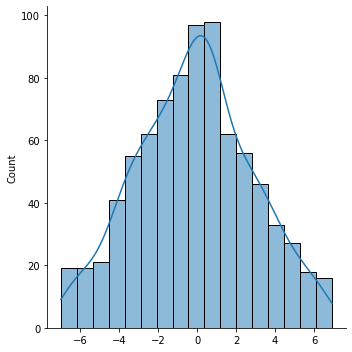

In [60]:
fig = sns.displot(data = output_show,kind = 'hist',kde = "TRUE")